In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook")
from scipy.stats import norm
from sklearn.cluster import KMeans
import pylab 
import scipy.stats as stats

DATA_DIR = 'data'

In [2]:
# load the mean tone a country has about itself
country_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_view.csv')).dropna()  # 3 rows have no mention_country
country_inner_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_view.csv'))
country_outer_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_view.csv'))
country_inner_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_type_view.csv'))
country_outer_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_type_view.csv'))
country_to_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_type_view.csv'))
media_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'media_to_country_view.csv.zip'))

# Test christophe 

In [3]:
most_count_mentions = country_to_country_view[country_to_country_view["count_mentions"] >2000000]
most_count_mentions["actor_country"]

2554             Russia
3020     United Kingdom
6321               Iran
8490              China
9757      United States
10289             Syria
10681            Turkey
12853     United States
13469              Iraq
13885            France
14660     United States
14865           Germany
15909            Mexico
16026             India
16301            Israel
16399            Canada
18660            Israel
21399     United States
21794           Nigeria
22355             Japan
22852    United Kingdom
23472            Canada
24443         Australia
27042     United States
Name: actor_country, dtype: object

We decide to take only the row when we have more than 2 millions of count_mentions. We can see that we have 24 rows.
For the actor_country we have :
            - Russia
            - United Kingdom
            - Iran
            - China ...

In [4]:
most_count_mentions["mention_country"]

2554      United States
3020     United Kingdom
6321      United States
8490      United States
9757      United States
10289     United States
10681     United States
12853            Canada
13469     United States
13885     United States
14660             India
14865     United States
15909     United States
16026             India
16301            Israel
16399            Canada
18660     United States
21399    United Kingdom
21794           Nigeria
22355     United States
22852     United States
23472     United States
24443         Australia
27042         Australia
Name: mention_country, dtype: object

We can see that for mention_country United States appears 14 times !

In [5]:
most_count_mentions_USA = most_count_mentions[most_count_mentions["mention_country"] == "United States"]
most_count_mentions_USA

,actor_country,mention_country,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
2554,Russia,United States,-3.192588,2.717061,7210348,1552467,34.005404,-3.234261,4.410215,-4.855072,-3.022453,-1.385042
6321,Iran,United States,-3.040677,2.607964,3219911,767387,36.756041,-2.983357,4.018915,-4.525288,-2.799378,-1.365188
8490,China,United States,-2.040634,2.979879,4361879,1250426,40.302753,-2.021240,4.151942,-3.739316,-1.990950,-0.169924
9757,United States,United States,-2.640899,3.711687,117917260,28011457,39.359858,-2.609543,5.103107,-4.933333,-2.345679,-0.135870
10289,Syria,United States,-4.666384,2.630926,4363773,910725,34.339758,-4.765086,5.127742,-6.341463,-4.621514,-2.922078
10681,Turkey,United States,-4.478862,2.972262,3559712,746951,37.014562,-4.573972,5.417933,-6.316812,-4.429967,-2.632324
13469,Iraq,United States,-3.840010,2.630240,2515025,589231,37.203443,-3.925944,4.603176,-5.360134,-3.734440,-2.179487
13885,France,United States,-3.135730,3.584924,4445363,1028751,37.329017,-3.127428,5.227597,-5.610561,-3.001464,-0.709220
14865,Germany,United States,-3.165261,3.454475,3416648,868468,38.282395,-3.173712,5.176284,-5.468400,-3.040541,-0.747384
15909,Mexico,United States,-2.962328,3.379020,2139025,581721,36.651175,-3.014493,5.014489,-5.086705,-2.814815,-0.705882


We can see that for actor_country Asia, Europe , North and South America are represented.

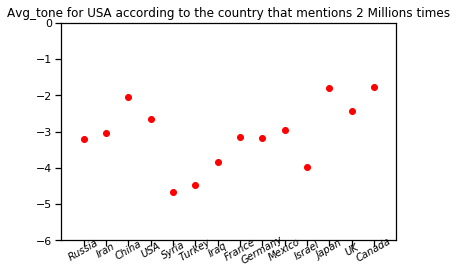

In [6]:
plt.plot(most_count_mentions_USA["actor_country"],most_count_mentions_USA["avg_tone"] , 'ro')
axes = plt.gca()
plt.title('Avg_tone for USA according to the country that mentions 2 Millions times')
axes.set_xlim(-1, 14)
axes.set_ylim(-6, 0)
axes.xaxis.set_ticklabels(['Russia', 'Iran', 'China', 'USA',
                           'Syria','Turkey','Iraq','France',
                          'Germany','Mexico','Israel',
                          'Japan','UK','Canada'], rotation = 30, color = 'black', fontsize = 10, style = 'italic', verticalalignment = 'center')
plt.show()

In [7]:
country_inner_view[country_inner_view["country"] == "United States"]

,country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
88,United States,-2.640899,3.711687,117917260,28011457,39.359858,-2.609543,5.103107,-4.931973,-2.348578,-0.138122


In [8]:
country_outer_view[country_outer_view["country"] == "United States"]

,country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
84,United States,-2.309722,3.519255,16830093,6566142,40.17088,-2.189076,4.68348,-4.607206,-2.201258,0.0


In [9]:
a = most_count_mentions_USA[["stddev_tone","avg_tone"]]
#a.values
kmeans = KMeans(n_clusters=3, random_state=0).fit(a.values)
d = {'actor_country': most_count_mentions_USA["actor_country"], 'labels': kmeans.labels_ , 'continent': ["Europe","Asia","Asia","Amerique","Asia","Asia","Asia","Europe","Europe","Amerique","Asia","Asia","Europe","Amerique"] }
df = pd.DataFrame(data=d)
df

,actor_country,labels,continent
2554,Russia,2,Europe
6321,Iran,2,Asia
8490,China,1,Asia
9757,United States,2,Amerique
10289,Syria,0,Asia
10681,Turkey,0,Asia
13469,Iraq,0,Asia
13885,France,2,Europe
14865,Germany,2,Europe
15909,Mexico,2,Amerique


In [10]:
df[df["labels"] == 2]

,actor_country,labels,continent
2554,Russia,2,Europe
6321,Iran,2,Asia
9757,United States,2,Amerique
13885,France,2,Europe
14865,Germany,2,Europe
15909,Mexico,2,Amerique
22852,United Kingdom,2,Europe


In [11]:
df[df["labels"] == 1]

,actor_country,labels,continent
8490,China,1,Asia
22355,Japan,1,Asia
23472,Canada,1,Amerique


In [12]:
df[df["labels"] == 0]

,actor_country,labels,continent
10289,Syria,0,Asia
10681,Turkey,0,Asia
13469,Iraq,0,Asia
18660,Israel,0,Asia


### Test all country

In [13]:
mention_10000 = country_to_country_view[country_to_country_view["count_mentions"] >10000]
USA = mention_10000[mention_10000["mention_country"] == "United States"]
b = USA[["stddev_tone","avg_tone"]]
kmeans = KMeans(n_clusters=10, random_state=0).fit(b.values)
d = {'actor_country': USA["actor_country"], 'labels': kmeans.labels_  }
df = pd.DataFrame(data=d)
df[df["labels"] == 1]

,actor_country,labels
164,Croatia,1
652,Niger,1
698,Central African Republic,1
1680,Vanuatu,1
8934,Egypt,1
10289,Syria,1
10681,Turkey,1
11410,Hungary,1
13469,Iraq,1
13826,Ukraine,1


## Difference between country_outer_view and country_inner_view for each country 

In [14]:
df = pd.DataFrame(columns=['actor_country','difference'])
country = country_inner_view["country"].values
for i in country:
        #a = country_inner_view["country"][i]
        value = country_outer_view[country_outer_view["country"] == i]["avg_tone"].values - country_inner_view["avg_tone"][country_inner_view["country"] == i].values
        df = df.append({'actor_country': i, 'difference' : value}, ignore_index=True)
        
df.head()

,actor_country,difference
0,Yemen,[-0.8027051466627153]
1,Guyana,[0.26112578003271825]
2,Malaysia,[-1.412187341461172]
3,Singapore,[0.2782952080297385]
4,Iraq,[-0.2791562128557836]


A negative difference means that the country has a better reputation in this country than from outside

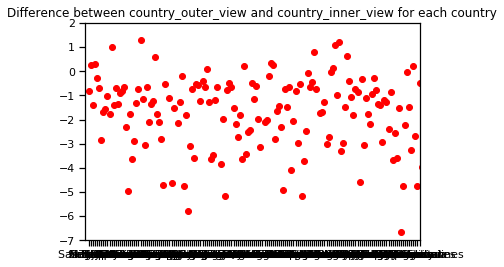

In [15]:
plt.plot(df["actor_country"],df["difference"] , 'ro')
axes = plt.gca()
plt.title('Difference between country_outer_view and country_inner_view for each country')
axes.set_xlim(-2, 160)
axes.set_ylim(-7, 2)

plt.show()

Text(0,0.5,'nombres')

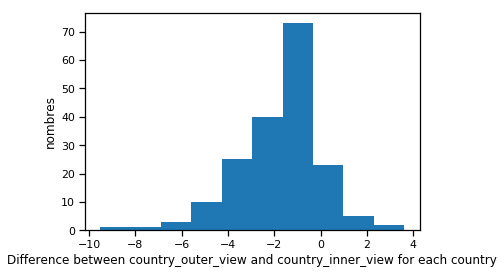

In [16]:
x = df["difference"].astype(float)
plt.hist(x)
plt.xlabel('Difference between country_outer_view and country_inner_view for each country')
plt.ylabel('nombres')

We can see that the histogram seems to be an histogram of a gaussian distribution. If we use describe we observe that the mean is -1.59 and the std is 1.35.

In [17]:
x.describe()

count    183.000000
mean      -1.733244
std        1.785616
min       -9.533043
25%       -2.755870
50%       -1.482436
75%       -0.643204
max        3.612598
Name: difference, dtype: float64

To have a better visualization , we decide to use the Q-Q plot.It is a graphical method for comparing two probability distributions by plotting their quantiles against each other.

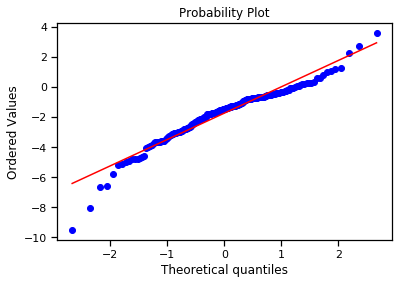

In [18]:
stats.probplot(x, dist="norm", plot=pylab)
pylab.show()

The linearity of the points suggests that the data are normally distributed.

In [19]:
df[df["difference"] > 0]

,actor_country,difference
1,Guyana,[0.26112578003271825]
3,Singapore,[0.2782952080297385]
11,Cuba,[0.9933943529090767]
25,Mozambique,[1.2942481949958387]
32,Colombia,[0.6037035431218918]
38,Paraguay,[2.2435435314378775]
42,Chad,[2.758334877007508]
57,France,[0.09866522329527871]
75,Lesotho,[0.2315436583590038]
84,Suriname,[3.612598284727395]


Only 14 countries have a better reputation from outside than inside.

In [20]:
(df[df["difference"] < 0].count() [0] /  df["difference"].count()) *100

89.61748633879782

90,6% of the coutry have better  image of them compared to the think of the other countries.

In [21]:
df[df["difference"] < -4]

,actor_country,difference
19,Guatemala,[-4.9518153974026795]
36,Anguilla,[-4.711619714260965]
40,Eritrea,[-4.625631641604285]
46,Djibouti,[-4.764820283387889]
48,Ivory Coast,[-5.790886655283363]
63,West Bank,[-8.032777647724215]
66,Dominica,[-5.172018604005151]
94,Laos,[-4.92241516964811]
98,Turkmenistan,[-4.07452951749009]
103,Democratic Republic of the Congo,[-5.147710509872504]


Why such a difference ?

In [22]:
Anguilla = country_to_country_view[country_to_country_view["mention_country"] == "Anguilla"]
Anguilla[Anguilla["count_mentions"] > 100 ]

,actor_country,mention_country,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
1678,United States,Anguilla,1.651052,2.848094,317,311,41.356467,1.572465,3.331309,-0.225225,1.845638,3.947368
6657,United Kingdom,Anguilla,0.977449,2.199307,455,448,40.219780,1.084351,2.820023,-0.877193,0.982659,2.167183
19303,Anguilla,Anguilla,2.073790,3.367414,2242,2119,53.617306,1.819713,4.415703,0.284900,2.410800,4.205607


For Anguilla that is a British overseas territory in the Caribbean, we note that only three countries have spoken more than 100 times about this territory. The country that cited the most Anguilla it's Anguilla itself.

In [23]:
Dominica = country_to_country_view[country_to_country_view["mention_country"] == "Dominica"]
Dominica[Dominica["count_mentions"] > 200 ]

,actor_country,mention_country,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
22274,United States,Dominica,0.678507,4.383362,343,292,53.381924,0.813914,4.716866,-2.263374,1.687764,4.069767
22455,Dominica,Dominica,1.950134,3.261322,2446,1904,56.295993,1.920815,4.008679,0.160514,2.259887,4.102564


In [24]:
Turkmenistan = country_to_country_view[country_to_country_view["mention_country"] == "Turkmenistan"]
Turkmenistan[Turkmenistan["count_mentions"] > 200 ]

,actor_country,mention_country,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
2431,Turkmenistan,Turkmenistan,3.204653,3.602764,4081,4049,47.779956,3.131333,4.828484,1.722282,3.296703,5.291005
6249,Turkey,Turkmenistan,3.654789,3.721535,208,208,37.115385,3.321556,4.925136,0.842697,3.479853,6.326531
6759,Russia,Turkmenistan,2.246197,4.060645,320,317,41.312500,1.993653,4.969339,-0.815494,1.946903,5.494505
14803,Uzbekistan,Turkmenistan,2.600513,3.905260,234,231,31.282051,2.616542,5.682812,0.736196,3.246753,4.716981


Same observation for Dominica and Turkmenistan, for instance the country that cited the most Dominica it's Dominica itself and only the USA cited Anguilla more than 200 times.

In [25]:
Macedonia = country_to_country_view[country_to_country_view["mention_country"] == "Macedonia"]
Macedonia.describe()

,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,-2.485711,2.235637,465.114286,360.007143,40.001732,-2.506498,3.602074,-3.987048,-2.596675,-1.032731
std,2.387119,1.516603,1796.945494,1369.372143,15.489915,2.494082,2.134009,2.396752,2.520090,2.995979
min,-8.333333,0.000000,1.000000,1.000000,10.000000,-8.773864,0.000000,-11.274510,-9.545455,-8.333333
25%,-3.849520,1.128074,7.750000,6.000000,33.303571,-3.909378,2.473885,-5.404008,-4.128744,-2.935421
50%,-2.354274,2.573116,46.500000,37.000000,37.184824,-2.363692,3.804344,-4.097702,-2.601307,-0.668602
75%,-1.239574,3.252724,233.250000,174.250000,43.259804,-1.232994,4.690516,-2.883194,-1.569551,0.705494
max,8.363636,6.726507,18990.000000,14368.000000,100.000000,8.363636,10.929243,8.363636,8.363636,10.687023


In [26]:
Bahrain = country_to_country_view[country_to_country_view["mention_country"] == "Bahrain"]
Bahrain.describe()

,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,-1.866617,3.570544,796.529101,595.899471,40.231127,-1.892825,4.939031,-4.510671,-2.059518,0.508920
std,3.035935,1.761109,2477.628206,1959.926148,11.343755,3.060059,2.092230,3.688552,3.459361,3.384353
min,-10.645658,0.000000,1.000000,1.000000,15.625000,-10.484562,0.000000,-13.366337,-13.366337,-7.759700
25%,-3.911626,2.987853,20.000000,13.000000,34.864865,-3.870653,3.842811,-6.881720,-4.497354,-1.460823
50%,-2.229975,3.947990,70.000000,46.000000,39.025522,-2.243753,5.352305,-5.263158,-2.258065,0.416667
75%,-0.481343,4.725277,419.000000,274.000000,43.459119,-0.357451,6.366726,-2.894356,-0.445434,2.857143
max,8.184143,8.670034,23694.000000,20498.000000,100.000000,8.184143,10.213191,8.184143,8.184143,9.183673


In [27]:
Eritrea = country_to_country_view[country_to_country_view["mention_country"] == "Eritrea"]
Eritrea.describe()

,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,-1.501866,2.480353,207.828358,186.149254,42.070011,-1.364598,3.867503,-3.154771,-1.776653,0.217768
std,3.075452,1.851814,1088.276022,933.306601,16.852837,3.077244,2.191623,3.222977,3.306307,3.767703
min,-11.810953,0.000000,1.000000,1.000000,10.000000,-9.804450,0.000000,-13.978495,-13.978495,-9.693053
25%,-3.680382,0.583439,5.000000,4.000000,33.461538,-3.304647,2.478671,-4.968505,-3.904282,-2.584313
50%,-1.731520,2.920617,17.000000,16.000000,39.199247,-1.493428,4.288754,-3.873371,-2.312216,-0.240077
75%,0.100200,3.895792,55.750000,51.250000,46.115385,0.006235,5.323078,-1.559726,-0.155925,3.103117
max,9.459459,8.223320,12081.000000,10243.000000,100.000000,9.459459,11.247898,9.459459,9.459459,11.200000


For Eritrea , Bahrain and Macedonia, the analysis is different. the difference of view within and outside this country is no longer due to a small count of event but rather in conflicts with others countries.

This example shows that we have to be very carefull about the analysis of the data and all the countries that have a bad avg_tone are not necessarily in conflict. The lack of events can lead to misinterpretation.

In [28]:
count = pd.DataFrame(columns=['country','count'])
country = country_inner_view["country"].values
for i in country:
        #a = country_inner_view["country"][i]
        value = country_outer_view[country_outer_view["country"] == i]["count_mentions"].values + country_inner_view["count_mentions"][country_inner_view["country"] == i].values
        if (value < 10000):
            value =0
        if ( 9999 <value < 100000):
            value =1
        if (99999 < value < 10000000 ) :
            value = 2
        if (999999 < value ) :
            value = 3

        count = count.append({'country': i, 'count' : value}, ignore_index=True)
count['count'] = count['count'].astype(float)

country = count["country"].values
val_0=0
val_1=0
val_2=0
val_3=0
for i in country :
    if (count[count["country"]==i]["count"].values == 0 ):
        val_0 = val_0 +1
    if (count[count["country"]==i]["count"].values == 1 ):
        val_1 = val_1 +1
    if (count[count["country"]==i]["count"].values == 2 ):
        val_2 = val_2 +1
    if (count[count["country"]==i]["count"].values == 3 ):
        val_3 = val_3 +1

final_count = pd.DataFrame(columns=['total country','count'])
final_count = final_count.append({'total country': val_0, 'count' : "less than ten thousand "}, ignore_index=True)
final_count = final_count.append({'total country': val_1, 'count' : "between ten thousand and hundred thousand  mentions"}, ignore_index=True)
final_count = final_count.append({'total country': val_2, 'count' : "between a hundred thousand  and one million mentions"}, ignore_index=True)
final_count = final_count.append({'total country': val_3, 'count' : "more than one million mentions"}, ignore_index=True)
final_count.to_csv('count_event.csv')

In [29]:
count_map = pd.DataFrame(columns=['country','count'])
country = country_inner_view["country"].values
for i in country:
        value = country_outer_view[country_outer_view["country"] == i]["count_mentions"].values + country_inner_view["count_mentions"][country_inner_view["country"] == i].values
    
        if (i == "United States"):
            value = value /10
        count_map = count_map.append({'country': i, 'count' : value}, ignore_index=True)
count_map['count'] = count_map['count'].astype(float)

count_map.to_csv('count_map.csv')



In [30]:
graphe_negative = country_to_country_view[country_to_country_view["avg_tone"] < 0][country_to_country_view["count_mentions"] > 100000]
graphe_negative.head()
graphe_negative.to_csv("graphe.csv")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [31]:
import networkx as nx

graph_negative =nx.from_pandas_edgelist(graphe_negative, 'actor_country', 'mention_country', edge_attr=None, create_using= nx.Graph())
print(nx.info(graph_negative))

Name: 
Type: Graph
Number of nodes: 111
Number of edges: 238
Average degree:   4.2883


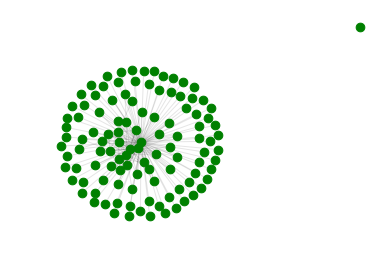

In [40]:
# plot it out
pos = nx.spring_layout(graph_negative,k=0.2)
ec = nx.draw_networkx_edges(graph_negative, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(graph_negative, pos, nodelist=graph_negative.nodes(), node_color='g', cmap=plt.cm.jet, node_shape='.')
plt.axis('off')
plt.savefig('graph.png')
plt.show()


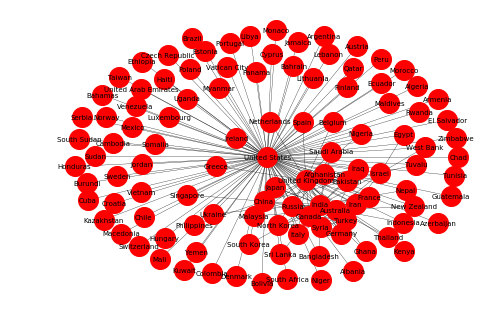

In [41]:
subgraph_USA = graph_negative.subgraph(['United States']+list(graph_negative.neighbors('United States')))
nx.draw_spring(subgraph_USA, with_labels=True, node_size=400,font_size=7, width=0.3 )
plt.savefig('graph2.png')

In [35]:
country_outer_view[country_outer_view["country"] == 'United States']

,country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
84,United States,-2.309722,3.519255,16830093,6566142,40.17088,-2.189076,4.68348,-4.607206,-2.201258,0.0
